In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

sns.set_style("white")

In [2]:
df = pd.read_csv('allTogether.csv')

# remove ids and numbers
df = df.drop(['_id','question.number'], axis=1)
# groupNames, majLabel and colors are synonyms
df = df.drop(['question.groupNames','question.colors'], axis=1)
# rND' is labeled in reverse
df['question.new_rND'] = 2 - df['question.new_rND']

# add absolute version of the cv score (demographic parity)
df['question.abs_cv'] = df['question.cv']
df.loc[df['question.cv']>1, 'question.abs_cv'] = 2-df['question.cv']
# add absolute version of the rND' score (demographic parity)
df['question.abs_rND'] = df['question.new_rND']
df.loc[df['question.new_rND']>1, 'question.abs_rND'] = 2-df['question.new_rND']
# add absolute versions of comparative accuracy scores
df['question.abs_s_tnr'] = df['question.s_tnr']
df.loc[df['question.s_tnr']>1, 'question.abs_s_tnr'] = 2-df['question.s_tnr']
df['question.abs_s_tpr'] = df['question.s_tpr']
df.loc[df['question.s_tpr']>1, 'question.abs_s_tpr'] = 2-df['question.s_tpr']
df['question.abs_s_bcr'] = df['question.s_bcr']
df.loc[df['question.s_bcr']>1, 'question.abs_s_bcr'] = 2-df['question.s_bcr']
# add absolute versions of comparative adjusted accuracy scores
df['question.abs_s_adj_tnr'] = df['question.s_adj_tnr']
df.loc[df['question.s_adj_tnr']>1, 'question.abs_s_adj_tnr'] = 2-df['question.s_adj_tnr']
df['question.abs_s_adj_tpr'] = df['question.s_adj_tpr']
df.loc[df['question.s_adj_tpr']>1, 'question.abs_s_adj_tpr'] = 2-df['question.s_adj_tpr']
df['question.abs_s_adj_bcr'] = df['question.s_adj_bcr']
df.loc[df['question.s_adj_bcr']>1, 'question.abs_s_adj_bcr'] = 2-df['question.s_adj_bcr']
pd.set_option('display.max_columns', None)
df.head()

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user._id,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.abs_cv,question.abs_rND,question.abs_s_tnr,question.abs_s_tpr,question.abs_s_bcr,question.abs_s_adj_tnr,question.abs_s_adj_tpr,question.abs_s_adj_bcr
0,0.89,0.84,36.534,selection,3,7,female,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.00,1.000000,NaN,NaN,1.000000,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.285714,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN
1,0.58,NaN,16.849,selection,5,5,female,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.80,0.854167,1.000000,0.927083,0.898551,1.0,0.5,0.75,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.600000,NaN,0.500000,0.666667,0.916667,0.666667,0.854167,0.906250
2,0.39,0.06,12.849,selection,4,6,male,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.75,1.000000,0.791045,0.895522,0.827160,0.5,1.0,0.75,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.666667,NaN,0.666667,0.500000,0.916667,0.791045,0.730769,0.969862
3,0.25,NaN,10.424,selection,4,6,female,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.50,0.395349,1.000000,0.697674,0.500000,1.0,0.6,0.80,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.750000,NaN,0.600000,0.333333,0.866667,0.747967,0.395349,0.823691
4,0.05,0.13,8.199,selection,1,9,female,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.00,NaN,0.000000,NaN,0.000000,0.0,1.0,0.50,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN


In [3]:
users = df['user._id'].unique()

df_results = pd.DataFrame(columns=['id', 'accuracy', 's_accuracy', 'genderParity',
                                   'accuracy_R2', 's_accuracy_R2', 'abs_cv_R2', 'ordering_utility_R2', 'rND_R2'])

for user in users:
    questions = df[df['user._id'] == user].reset_index(drop = True)
    sel_questions = questions[questions['question.questionType'] == 'selection']
    ran_questions = questions[questions['question.questionType'] == 'ranking']
    cv = pg.corr(sel_questions.rating, sel_questions['question.abs_cv'], method="spearman")
    accuracy = pg.corr(sel_questions.rating, sel_questions['question.adj_accuracy'], method="spearman")
    s_accuracy = pg.corr(sel_questions.rating, sel_questions['question.s_adj_accuracy'], method="spearman")
    ordering_utility = pg.corr(ran_questions.rating, ran_questions['question.ordering_utility'], method="spearman")
    rND = pg.corr(ran_questions.rating, ran_questions['question.abs_rND'], method="spearman")
    new_row = {'id': user,
               'accuracy': questions['user.accuracy'][0],
               's_accuracy': questions['user.comparativeAccuracy'][0],
               'genderParity': questions['user.genderParity'][0],
               'abs_cv_R2': cv.r2[0],
               'accuracy_R2': accuracy.r2[0],
               's_accuracy_R2': s_accuracy.r2[0],
               'ordering_utility_R2': ordering_utility.r2[0],
               'rND_R2': rND.r2[0],
               'gender': questions['user.gender'][0],
              }
    df_results = df_results.append(new_row, ignore_index=True)

df_results.head()

/usr/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,id,accuracy,s_accuracy,genderParity,accuracy_R2,s_accuracy_R2,abs_cv_R2,ordering_utility_R2,rND_R2,gender
0,ObjectId(5f350096c9eafb2f751e4c21),0.86,0.34,0.73,0.798559,0.665876,0.119339,0.669421,0.008264,male
1,ObjectId(5f3509561684e531101576e7),0.93,0.53,0.51,0.703769,0.423097,0.226205,0.157092,0.281428,female
2,ObjectId(5f350a3a1684e531101576e8),1.00,0.20,0.25,0.320716,0.000000,0.051629,0.267273,0.008523,male
3,ObjectId(5f350d0b1684e531101576ec),0.95,0.05,0.20,0.553186,0.644025,0.800746,0.873711,0.007713,male
4,ObjectId(5f350f631684e531101576f4),0.48,0.50,0.48,0.127309,0.227174,0.181582,0.236810,0.072254,other


# R² and user statements

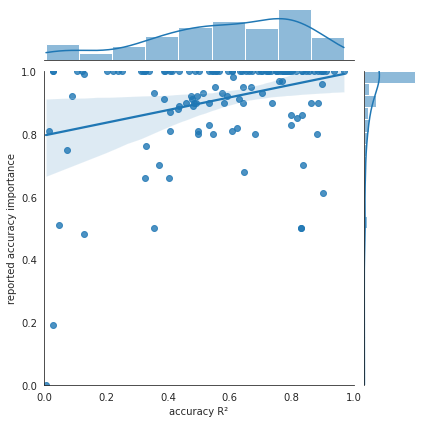

In [4]:
g = sns.jointplot(
    data=df_results,
    x="accuracy_R2", y="accuracy",
    xlim=(0,1), ylim=(0,1),
    kind="reg"
)

g.set_axis_labels('accuracy R²', 'reported accuracy importance')

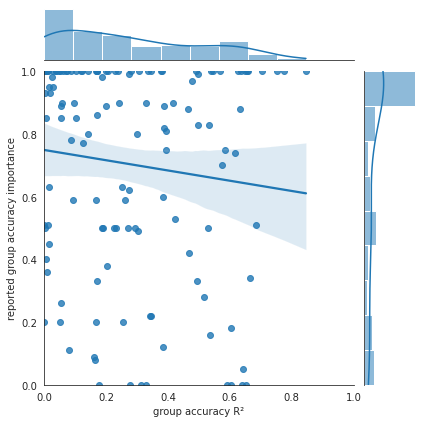

In [5]:
g = sns.jointplot(
    data=df_results,
    x="s_accuracy_R2", y="s_accuracy",
    xlim=(0,1), ylim=(0,1),
    kind="reg"
)

g.set_axis_labels('group accuracy R²', 'reported group accuracy importance')

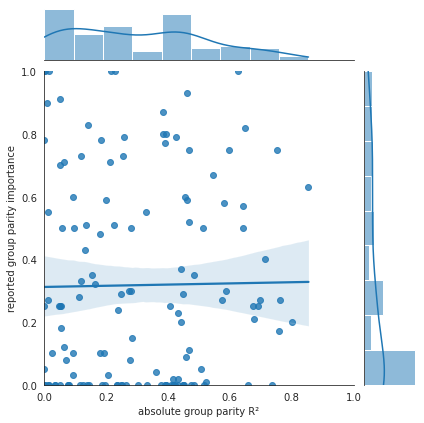

In [6]:
g = sns.jointplot(
    data=df_results,
    x="abs_cv_R2", y="genderParity",
    xlim=(0,1), ylim=(0,1),
    kind="reg"
)

g.set_axis_labels('absolute group parity R²', 'reported group parity importance')

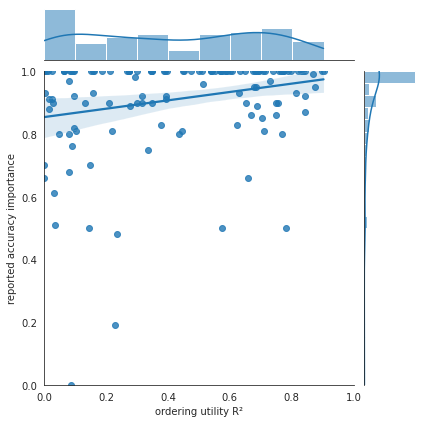

In [7]:
sns.set_style("white")
g = sns.jointplot(
    data=df_results,
    x="ordering_utility_R2", y="accuracy",
    xlim=(0,1), ylim=(0,1),
    kind="reg"
)

g.set_axis_labels('ordering utility R²', 'reported accuracy importance')

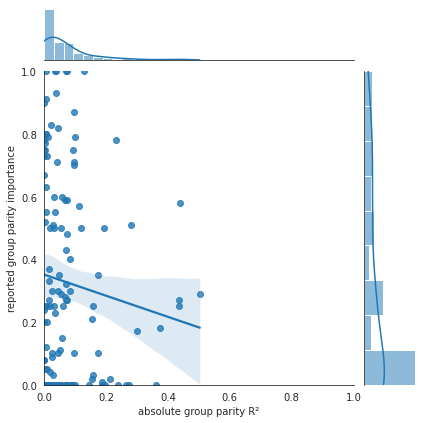

In [8]:
sns.set_style("white")
g = sns.jointplot(
    data=df_results,
    x="rND_R2", y="genderParity",
    xlim=(0,1), ylim=(0,1),
    kind="reg"
)

g.set_axis_labels('absolute group parity R²', 'reported group parity importance')

# Differences between R² and user statement by R²

In [9]:
df_results['diff_accuracy'] = df_results.accuracy - df_results.accuracy_R2
df_results['diff_s_accuracy'] = df_results.s_accuracy - df_results.s_accuracy_R2
df_results['diff_cv'] = df_results.genderParity - df_results.abs_cv_R2
df_results['diff_ordering_utility'] = df_results.accuracy - df_results.ordering_utility_R2
df_results['diff_rND'] = df_results.genderParity - df_results.rND_R2
df_results.head()

,id,accuracy,s_accuracy,genderParity,accuracy_R2,s_accuracy_R2,abs_cv_R2,ordering_utility_R2,rND_R2,gender,diff_accuracy,diff_s_accuracy,diff_cv,diff_ordering_utility,diff_rND
0,ObjectId(5f350096c9eafb2f751e4c21),0.86,0.34,0.73,0.798559,0.665876,0.119339,0.669421,0.008264,male,0.061441,-0.325876,0.610661,0.190579,0.721736
1,ObjectId(5f3509561684e531101576e7),0.93,0.53,0.51,0.703769,0.423097,0.226205,0.157092,0.281428,female,0.226231,0.106903,0.283795,0.772908,0.228572
2,ObjectId(5f350a3a1684e531101576e8),1.00,0.20,0.25,0.320716,0.000000,0.051629,0.267273,0.008523,male,0.679284,0.200000,0.198371,0.732727,0.241477
3,ObjectId(5f350d0b1684e531101576ec),0.95,0.05,0.20,0.553186,0.644025,0.800746,0.873711,0.007713,male,0.396814,-0.594025,-0.600746,0.076289,0.192287
4,ObjectId(5f350f631684e531101576f4),0.48,0.50,0.48,0.127309,0.227174,0.181582,0.236810,0.072254,other,0.352691,0.272826,0.298418,0.243190,0.407746


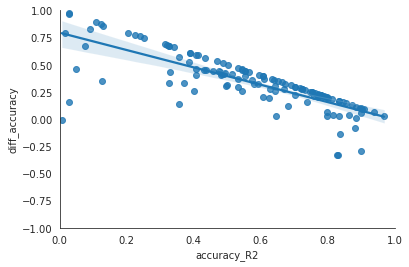

In [10]:
g = sns.regplot(data=df_results, x='accuracy_R2', y='diff_accuracy')
g.set(ylim=(-1, 1), xlim=(0, 1))
sns.despine()

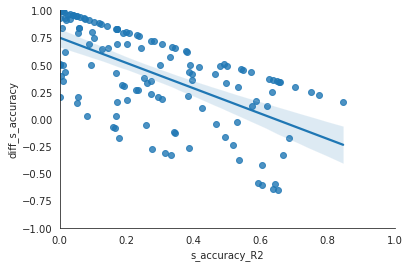

In [11]:
g = sns.regplot(data=df_results, x='s_accuracy_R2', y='diff_s_accuracy')
g.set(ylim=(-1, 1), xlim=(0, 1))
sns.despine()

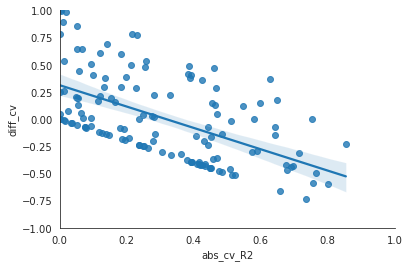

In [12]:
g = sns.regplot(data=df_results, x='abs_cv_R2', y='diff_cv')
g.set(ylim=(-1, 1), xlim=(0, 1))
sns.despine()

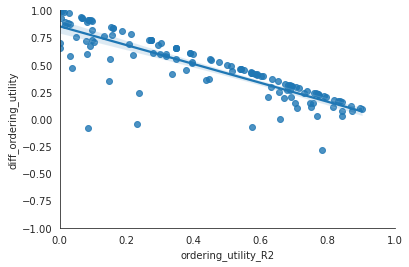

In [13]:
g = sns.regplot(data=df_results, x='ordering_utility_R2', y='diff_ordering_utility')
g.set(ylim=(-1, 1), xlim=(0, 1))
sns.despine()

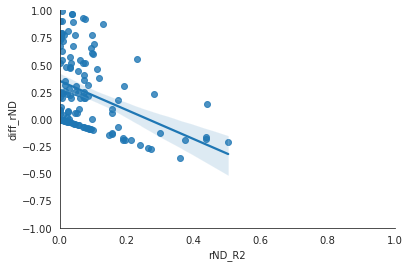

In [14]:
g = sns.regplot(data=df_results, x='rND_R2', y='diff_rND')
g.set(ylim=(-1, 1), xlim=(0, 1))
sns.despine()

# R² distributions by gender

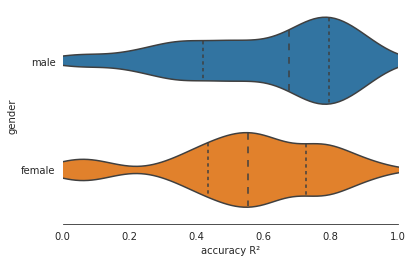

In [32]:
g = sns.violinplot(data=df_results[df_results.gender != 'other'], y='gender', x='accuracy_R2',
               scale='count', inner='quartile', bw=0.3)
g.set(xlim=(0, 1), xlabel='accuracy R²')
sns.despine(left=True)

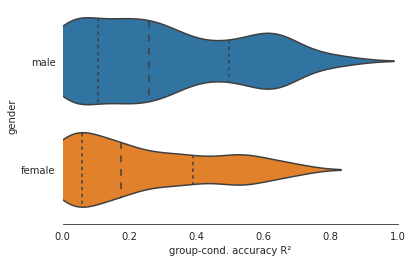

In [33]:
g = sns.violinplot(data=df_results[df_results.gender != 'other'], y='gender', x='s_accuracy_R2',
               scale='count', inner='quartile', bw=0.3)
g.set(xlim=(0, 1), xlabel='group-cond. accuracy R²')
sns.despine(left=True)

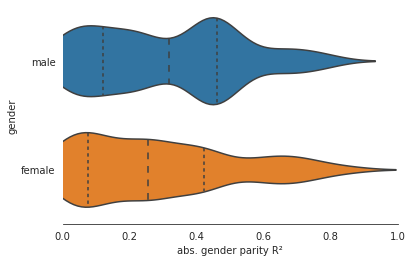

In [34]:
g = sns.violinplot(data=df_results[df_results.gender != 'other'], y='gender', x='abs_cv_R2',
               scale='count', inner='quartile', bw=0.3)
g.set(xlim=(0, 1), xlabel='abs. gender parity R²')
sns.despine(left=True)

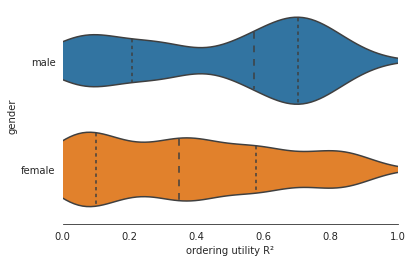

In [35]:
g = sns.violinplot(data=df_results[df_results.gender != 'other'], y='gender', x='ordering_utility_R2',
               scale='count', inner='quartile', bw=0.3)
g.set(xlim=(0, 1), xlabel='ordering utility R²')
sns.despine(left=True)

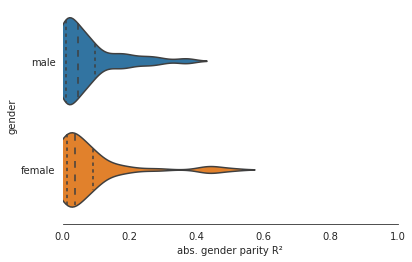

In [38]:
g = sns.violinplot(data=df_results[df_results.gender != 'other'], y='gender', x='rND_R2',
               scale='count', inner='quartile', bw=0.3)
g.set(xlim=(0, 1), xlabel='abs. gender parity R²')
sns.despine(left=True)

# Models predicting R² from demographics

In [20]:
cat_cols = [
    'language',
    'age',
    'edu',
    'gender',
]

y_cols = [
    'accuracy',
    's_accuracy',
    'genderParity',
]

r2_cols = [
    'accuracy_R2',
    's_accuracy_R2',
    'abs_cv_R2',
    'ordering_utility_R2',
    'rND_R2'
]

num_cols = [
    'believe',
    'confidence',
    'fear',
    'political',
    'religious',
    'screenHeight',
    'screenWidth',
    'will',
    'agreeableness',
    'conscientiousness',
    'extraversion',
    'neuroticism',
    'openness',
]

df_users = pd.DataFrame(columns=cat_cols+num_cols+y_cols+r2_cols)

for i in range(len(df_results)):
    user = df_results.iloc[i]
    user2 = df[df['user._id'] == user.id].iloc[0]
    new_row = {'accuracy': user['accuracy'],
               's_accuracy': user['s_accuracy'],
               'genderParity': user['genderParity'],
               'abs_cv_R2': user['abs_cv_R2'],
               'accuracy_R2': user['accuracy_R2'],
               's_accuracy_R2': user['s_accuracy_R2'],
               'ordering_utility_R2': user['ordering_utility_R2'],
               'rND_R2': user['rND_R2'],
               'believe': user2['user.believe'],
               'confidence': user2['user.confidence'],
               'fear': user2['user.fear'],
               'political': user2['user.political'],
               'religious': user2['user.religious'],
               'screenHeight': user2['user.screenHeight'],
               'screenWidth': user2['user.screenWidth'],
               'will': user2['user.will'],
               'agreeableness': user2['user.agreeableness'],
               'conscientiousness': user2['user.conscientiousness'],
               'extraversion': user2['user.extraversion'],
               'neuroticism': user2['user.neuroticism'],
               'openness': user2['user.openness'],
               'language': user2['user.language'],
               'age': user2['user.age'],
               'edu': user2['user.edu'],
               'gender': user2['user.gender'],
              }
    df_users = df_users.append(new_row, ignore_index=True)

df_users

,language,age,edu,gender,believe,confidence,fear,political,religious,screenHeight,screenWidth,will,agreeableness,conscientiousness,extraversion,neuroticism,openness,accuracy,s_accuracy,genderParity,accuracy_R2,s_accuracy_R2,abs_cv_R2,ordering_utility_R2,rND_R2
0,de,25,abitur,male,0.37,0.74,0.50,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.86,0.34,0.73,0.798559,0.665876,0.119339,0.669421,0.008264
1,de,25,abitur,female,0.69,0.61,0.66,0.52,0.48,748,360,0.53,4.0,4.5,3.0,2.5,4.0,0.93,0.53,0.51,0.703769,0.423097,0.226205,0.157092,0.281428
2,de,25,bachelor,male,0.60,0.51,0.75,0.80,0.70,732,412,0.40,4.0,3.5,4.0,2.0,4.5,1.00,0.20,0.25,0.320716,0.000000,0.051629,0.267273,0.008523
3,de,25,abitur,male,0.65,0.65,0.60,0.90,0.10,598,360,0.30,2.5,3.5,2.5,4.0,4.0,0.95,0.05,0.20,0.553186,0.644025,0.800746,0.873711,0.007713
4,de,76,none,other,0.49,0.51,0.49,0.52,0.51,732,412,0.50,NaN,NaN,NaN,NaN,NaN,0.48,0.50,0.48,0.127309,0.227174,0.181582,0.236810,0.072254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,de,25,abitur,female,0.52,0.52,0.53,0.49,0.49,720,1280,0.51,3.0,3.0,3.5,3.0,3.0,0.51,0.51,0.51,0.048186,0.010745,0.133849,0.035298,0.028973
132,en,25,bachelor,male,0.24,0.34,0.22,0.93,0.02,1080,1920,0.92,3.0,3.0,1.5,4.0,2.5,1.00,0.60,0.09,0.748391,0.384002,0.458264,0.690341,0.025606
133,de,25,abitur,female,0.59,0.67,0.13,0.81,0.00,1120,1792,1.00,2.0,4.0,3.0,3.0,4.0,1.00,0.74,0.00,0.854888,0.618151,0.475622,0.787731,0.023097
134,de,35,master,male,1.00,0.00,1.00,0.80,0.10,1080,1920,0.00,3.5,3.0,2.5,2.5,4.5,1.00,1.00,0.00,0.326655,0.071138,0.116883,NaN,NaN


In [21]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [22]:
# split for genderParity model
df_acc = df_users.copy()
df_acc = df_acc.dropna(subset=['abs_cv_R2'])
df_acc = df_acc.reset_index(drop=True)
y = df_acc.abs_cv_R2
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
est.fit(y.to_numpy().reshape(-1, 1))
y = est.transform(y.to_numpy().reshape(-1, 1)).ravel()

X = df_acc[num_cols + cat_cols]

# build the genderParity model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols),
     ('num', numerical_pipe, num_cols)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])

print("abs_cv_R2 model - RF test accuracy: %0.3f" % np.mean(cross_val_score(rf, X, y, cv=10)))

abs_cv_R2 model - RF test accuracy: 0.199


<ipython-input-23-a923748a0337>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


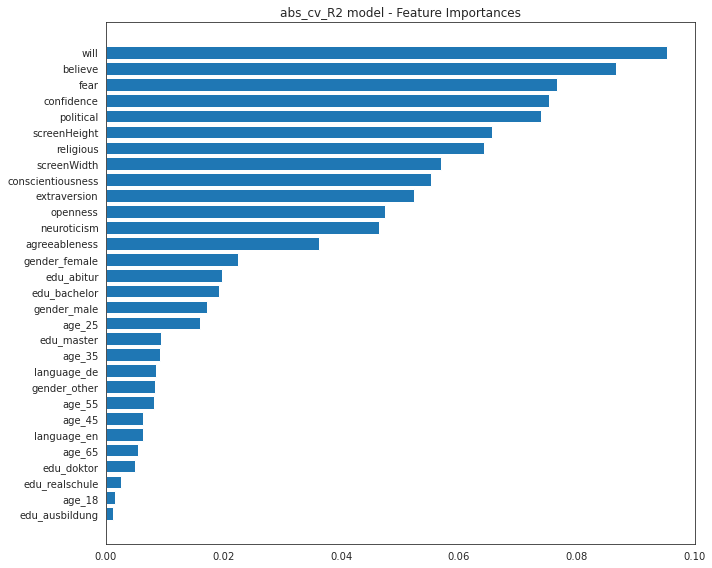

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
rf.fit(X_train, y_train)

ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=cat_cols)
feature_names = np.r_[feature_names, num_cols] # num_cols

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("abs_cv_R2 model - Feature Importances")
fig.tight_layout()
plt.show()

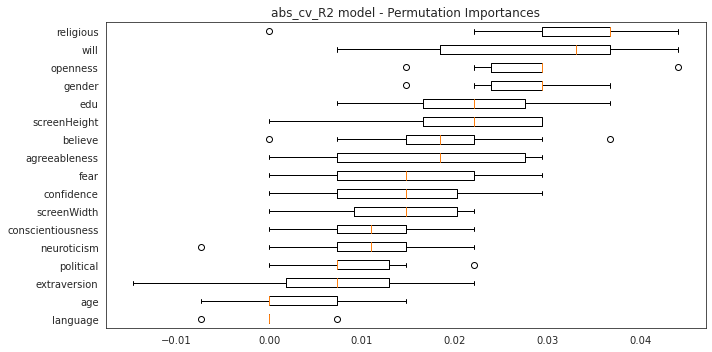

In [24]:
result = permutation_importance(rf, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("abs_cv_R2 model - Permutation Importances")
fig.tight_layout()
plt.show()

In [25]:
# split for accuracy model
df_acc = df_users.copy()
df_acc = df_acc.dropna(subset=['accuracy_R2'])
df_acc = df_acc.reset_index(drop=True)
y = df_acc.accuracy_R2
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
est.fit(y.to_numpy().reshape(-1, 1))
y = est.transform(y.to_numpy().reshape(-1, 1)).ravel()

X = df_acc[num_cols + cat_cols]

# build the s_accuracy model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols),
     ('num', numerical_pipe, num_cols)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])

print("accuracy_R2 model - RF test accuracy: %0.3f" % np.mean(cross_val_score(rf, X, y, cv=10)))

accuracy_R2 model - RF test accuracy: 0.280


<ipython-input-26-c0c22323e96d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


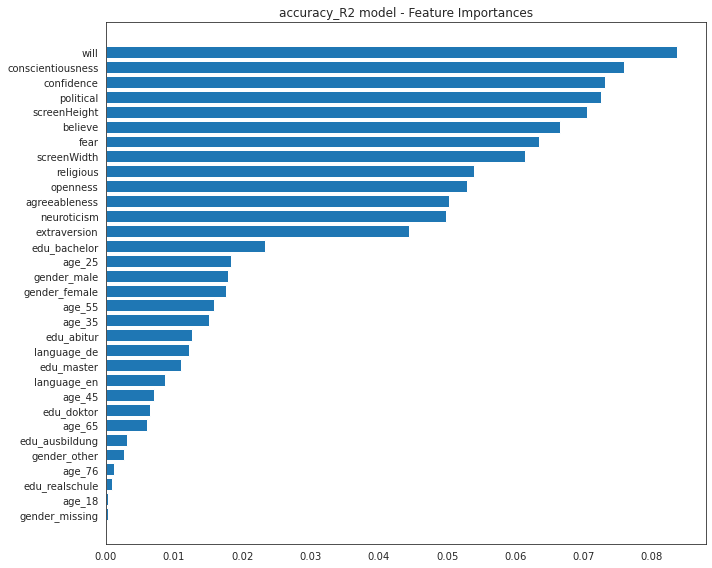

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
rf.fit(X_train, y_train)

ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=cat_cols)
feature_names = np.r_[feature_names, num_cols] # num_cols

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("accuracy_R2 model - Feature Importances")
fig.tight_layout()
plt.show()

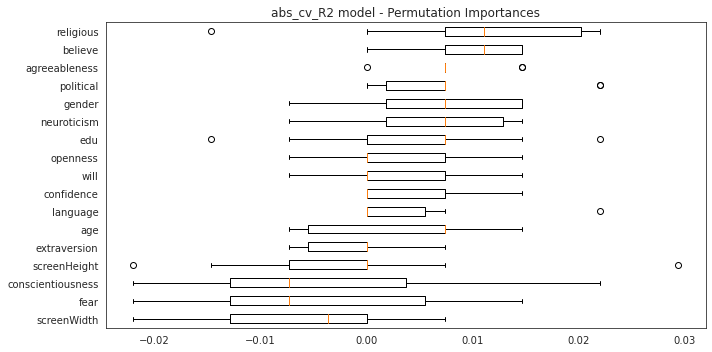

In [27]:
result = permutation_importance(rf, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("abs_cv_R2 model - Permutation Importances")
fig.tight_layout()
plt.show()

In [28]:
# split for s_accuracy model
df_acc = df_users.copy()
df_acc = df_acc.dropna(subset=['s_accuracy_R2'])
df_acc = df_acc.reset_index(drop=True)
y = df_acc.s_accuracy_R2
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
est.fit(y.to_numpy().reshape(-1, 1))
y = est.transform(y.to_numpy().reshape(-1, 1)).ravel()

X = df_acc[num_cols + cat_cols]

# build the s_accuracy model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols),
     ('num', numerical_pipe, num_cols)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])

print("s_accuracy_R2 model - RF test accuracy: %0.3f" % np.mean(cross_val_score(rf, X, y, cv=10)))

s_accuracy_R2 model - RF test accuracy: 0.205


<ipython-input-29-5dd2c664c31d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


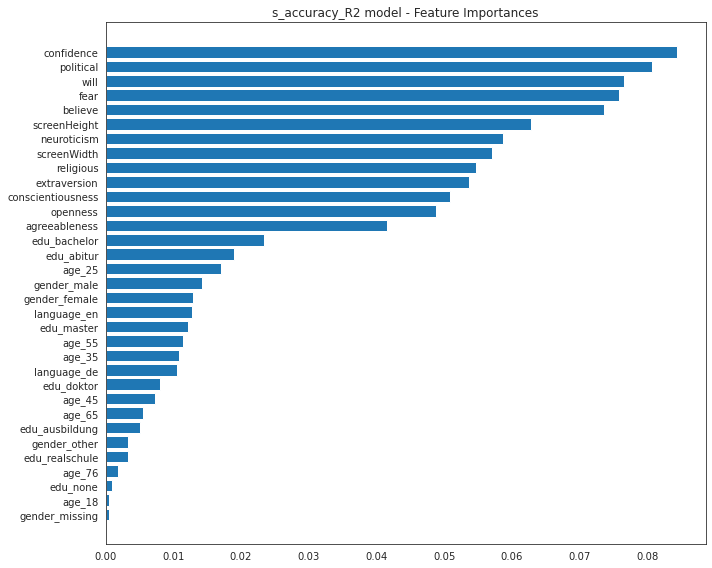

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
rf.fit(X_train, y_train)

ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=cat_cols)
feature_names = np.r_[feature_names, num_cols] # num_cols

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("s_accuracy_R2 model - Feature Importances")
fig.tight_layout()
plt.show()

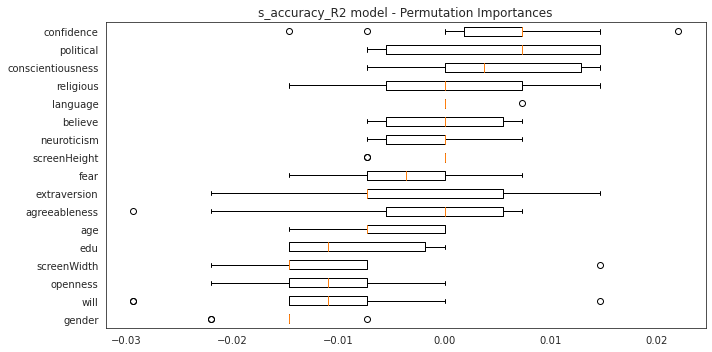

In [30]:
result = permutation_importance(rf, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("s_accuracy_R2 model - Permutation Importances")
fig.tight_layout()
plt.show()